# Track PU ID BTD training

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font',**{'family':'sans-serif', 'sans-serif':['Helvetica'], 'size':'20'})
plt.rcParams['figure.figsize'] = '10,10'
plt.style.use('seaborn-white')

In [3]:
df = pd.read_hdf('/scratch/spigazzi/MTD/TDR/TrackPUID/samples/input_tracks_train.hd5', stop=500000000)

In [4]:
df.columns

Index(['idx', 'pt', 'eta', 'phi', 'x', 'y', 'z', 'dzErr', 'dxyErr', 'chi2',
       'ndof', 't0', 'sigmat0', 'mtdt', 'path_len', 'probPi', 'probP', 'probK',
       'energy', 'btlMatchChi2', 'btlMatchTimeChi2', 'etlMatchChi2',
       'etlMatchTimeChi2', 'normalizedChi2', 'numberOfValidHits',
       'numberOfLostHits', 'numberOfValidPixelBarrelHits',
       'numberOfValidPixelEndcapHits', 'numberOfValidStripTIBHits',
       'numberOfValidStripTIDHits', 'numberOfValidStripTOBHits',
       'numberOfValidStripTECHits', 'numberOfValidHitsBTL',
       'numberOfValidHitsETL', 'isHighPurity', 'hasMTD', 'genPdgId', 'genPt',
       'genEta', 'genPhi', 'genDR', 'simIsFromPV', 'simPt', 'simEta', 'simPhi',
       'simZ', 'genVtx_x', 'genVtx_y', 'genVtx_z', 'genVtx_t', 'pv3d_valid',
       'pv3d_ntrks', 'pv3d_chi2', 'pv3d_x', 'pv3d_y', 'pv3d_z', 'pv4d_valid',
       'pv4d_ntrks', 'pv4d_chi2', 'pv4d_x', 'pv4d_y', 'pv4d_z', 'pv4d_t'],
      dtype='object')

In [5]:
df['dx'] = abs(df['x']-df['pv4d_x'])
df['dy'] = abs(df['y']-df['pv4d_y'])
df['dz'] = abs(df['z']-df['pv4d_z'])
df['dt'] = abs(df['t0']-df['pv4d_t'])

features = [
    'pt',
    'eta',
    'phi',
    'dx',
    'dy',
    'dz',
    'dzErr',
    'dxyErr',
    'chi2',
    'ndof',
    'numberOfValidHits',
    'numberOfValidPixelBarrelHits',
    'numberOfValidPixelEndcapHits'
    ]

MTD_features = [
    'dt',
    'sigmat0',
    'hasMTD',
    'btlMatchChi2',
    'btlMatchTimeChi2',
    'etlMatchChi2',
    'etlMatchTimeChi2',
    'mtdt',
    'path_len'
]

target = 'simIsFromPV'
event_sel = (abs(df['pv4d_z']-df['genVtx_z'])<0.01) & df['pv4d_valid']

pv_pu_ratio = float((df['simIsFromPV']==1).sum())/(df['simIsFromPV']==0).sum()
df['pu_weight'] = 1.
df.loc[df[target]==0, 'pu_weight'] = pv_pu_ratio
print(pv_pu_ratio, df.loc[df['simIsFromPV']==0, 'pu_weight'].sum()/df.loc[df['simIsFromPV']==1, 'pu_weight'].sum())

X = df[features + MTD_features][event_sel]
y = df[target][event_sel]
w = df['pu_weight'][event_sel]

0.0245998345227 1.0000000008945111


In [6]:
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, w, test_size=0.2, random_state=12345)

In [7]:
from xgboost import XGBClassifier 

In [8]:
clf3D = XGBClassifier(max_depth=5, n_estimators=500, nthread=8, objective='binary:logistic', subsample=0.75)
clf3D

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=8, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.75)

In [10]:
%time fitres3D = clf3D.fit(X_train[features], y_train, w_train, eval_set=[(X_test[features], y_test, w_test)], eval_metric='logloss', early_stopping_rounds=5)

[11:01:04] Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


[0]	validation_0-error:0.04818	validation_0-rmse:0.464875	validation_0-mae:0.464595	validation_0-logloss:0.625225	validation_1-error:0.048187	validation_1-rmse:0.464883	validation_1-mae:0.464602	validation_1-logloss:0.62524


Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.



Will train until validation_1-logloss hasn't improved in 5 rounds.


[1]	validation_0-error:0.046214	validation_0-rmse:0.433964	validation_0-mae:0.432907	validation_0-logloss:0.5689	validation_1-error:0.046251	validation_1-rmse:0.433979	validation_1-mae:0.43292	validation_1-logloss:0.568926


[2]	validation_0-error:0.047605	validation_0-rmse:0.406717	validation_0-mae:0.404444	validation_0-logloss:0.521515	validation_1-error:0.047667	validation_1-rmse:0.406737	validation_1-mae:0.404461	validation_1-logloss:0.521548


[3]	validation_0-error:0.047468	validation_0-rmse:0.382713	validation_0-mae:0.378847	validation_0-logloss:0.481261	validation_1-error:0.047543	validation_1-rmse:0.382742	validation_1-mae:0.378869	validation_1-logloss:0.481307


[4]	validation_0-error:0.04687	validation_0-rmse:0.361567	validation_0-mae:0.355808	validation_0-logloss:0.44678	validation_1-error:0.046953	validation_1-rmse:0.361605	validation_1-mae:0.355835	validation_1-logloss:0.446837


[5]	validation_0-error:0.046281	validation_0-rmse:0.343007	validation_0-mae:0.335059	validation_0-logloss:0.41712	validation_1-error:0.046323	validation_1-rmse:0.34305	validation_1-mae:0.335089	validation_1-logloss:0.417183


[6]	validation_0-error:0.046324	validation_0-rmse:0.326721	validation_0-mae:0.316355	validation_0-logloss:0.391458	validation_1-error:0.046361	validation_1-rmse:0.326772	validation_1-mae:0.316389	validation_1-logloss:0.391532


[7]	validation_0-error:0.045939	validation_0-rmse:0.312393	validation_0-mae:0.299459	validation_0-logloss:0.369091	validation_1-error:0.045995	validation_1-rmse:0.312451	validation_1-mae:0.299495	validation_1-logloss:0.369171


[8]	validation_0-error:0.045989	validation_0-rmse:0.299858	validation_0-mae:0.284203	validation_0-logloss:0.349583	validation_1-error:0.046039	validation_1-rmse:0.299925	validation_1-mae:0.284243	validation_1-logloss:0.349673


[9]	validation_0-error:0.045417	validation_0-rmse:0.28889	validation_0-mae:0.270453	validation_0-logloss:0.332541	validation_1-error:0.045465	validation_1-rmse:0.288961	validation_1-mae:0.270494	validation_1-logloss:0.332634


[10]	validation_0-error:0.045372	validation_0-rmse:0.279294	validation_0-mae:0.258019	validation_0-logloss:0.317588	validation_1-error:0.045414	validation_1-rmse:0.279372	validation_1-mae:0.258062	validation_1-logloss:0.317689


[11]	validation_0-error:0.045265	validation_0-rmse:0.27089	validation_0-mae:0.24675	validation_0-logloss:0.304419	validation_1-error:0.045298	validation_1-rmse:0.270971	validation_1-mae:0.246792	validation_1-logloss:0.304522


[12]	validation_0-error:0.045027	validation_0-rmse:0.263568	validation_0-mae:0.236604	validation_0-logloss:0.292854	validation_1-error:0.045061	validation_1-rmse:0.263653	validation_1-mae:0.236647	validation_1-logloss:0.292961


[13]	validation_0-error:0.04508	validation_0-rmse:0.257182	validation_0-mae:0.227472	validation_0-logloss:0.282705	validation_1-error:0.045106	validation_1-rmse:0.257272	validation_1-mae:0.227516	validation_1-logloss:0.282817


[14]	validation_0-error:0.045242	validation_0-rmse:0.251649	validation_0-mae:0.219205	validation_0-logloss:0.273753	validation_1-error:0.045267	validation_1-rmse:0.251741	validation_1-mae:0.219249	validation_1-logloss:0.273867


[15]	validation_0-error:0.044945	validation_0-rmse:0.246778	validation_0-mae:0.211707	validation_0-logloss:0.265819	validation_1-error:0.044967	validation_1-rmse:0.246873	validation_1-mae:0.211752	validation_1-logloss:0.265937


[16]	validation_0-error:0.044777	validation_0-rmse:0.242458	validation_0-mae:0.204892	validation_0-logloss:0.258745	validation_1-error:0.044808	validation_1-rmse:0.242556	validation_1-mae:0.204939	validation_1-logloss:0.258867


[17]	validation_0-error:0.044763	validation_0-rmse:0.238732	validation_0-mae:0.198779	validation_0-logloss:0.252539	validation_1-error:0.044812	validation_1-rmse:0.238835	validation_1-mae:0.198828	validation_1-logloss:0.252666


[18]	validation_0-error:0.044785	validation_0-rmse:0.235434	validation_0-mae:0.193239	validation_0-logloss:0.247036	validation_1-error:0.044843	validation_1-rmse:0.235538	validation_1-mae:0.193287	validation_1-logloss:0.247164


[19]	validation_0-error:0.04478	validation_0-rmse:0.232574	validation_0-mae:0.188221	validation_0-logloss:0.24218	validation_1-error:0.044839	validation_1-rmse:0.232678	validation_1-mae:0.188268	validation_1-logloss:0.242307


[20]	validation_0-error:0.044781	validation_0-rmse:0.229984	validation_0-mae:0.183661	validation_0-logloss:0.237819	validation_1-error:0.04483	validation_1-rmse:0.230086	validation_1-mae:0.183706	validation_1-logloss:0.237946


[21]	validation_0-error:0.044642	validation_0-rmse:0.227805	validation_0-mae:0.179617	validation_0-logloss:0.234039	validation_1-error:0.044703	validation_1-rmse:0.22791	validation_1-mae:0.179664	validation_1-logloss:0.234169


[22]	validation_0-error:0.044551	validation_0-rmse:0.22576	validation_0-mae:0.175902	validation_0-logloss:0.23061	validation_1-error:0.044605	validation_1-rmse:0.225869	validation_1-mae:0.175951	validation_1-logloss:0.230744


[23]	validation_0-error:0.044586	validation_0-rmse:0.224073	validation_0-mae:0.172584	validation_0-logloss:0.227636	validation_1-error:0.044633	validation_1-rmse:0.224182	validation_1-mae:0.172632	validation_1-logloss:0.227772


[24]	validation_0-error:0.044432	validation_0-rmse:0.222444	validation_0-mae:0.169514	validation_0-logloss:0.224903	validation_1-error:0.044482	validation_1-rmse:0.222554	validation_1-mae:0.169563	validation_1-logloss:0.225039


[25]	validation_0-error:0.044441	validation_0-rmse:0.221056	validation_0-mae:0.166732	validation_0-logloss:0.222515	validation_1-error:0.044502	validation_1-rmse:0.221169	validation_1-mae:0.166783	validation_1-logloss:0.222655


[26]	validation_0-error:0.044511	validation_0-rmse:0.219855	validation_0-mae:0.164259	validation_0-logloss:0.220464	validation_1-error:0.044547	validation_1-rmse:0.21997	validation_1-mae:0.16431	validation_1-logloss:0.220606


[27]	validation_0-error:0.044535	validation_0-rmse:0.218871	validation_0-mae:0.162095	validation_0-logloss:0.21866	validation_1-error:0.044581	validation_1-rmse:0.218989	validation_1-mae:0.162147	validation_1-logloss:0.218806


[28]	validation_0-error:0.044504	validation_0-rmse:0.217915	validation_0-mae:0.160031	validation_0-logloss:0.216982	validation_1-error:0.044538	validation_1-rmse:0.218034	validation_1-mae:0.160082	validation_1-logloss:0.21713


[29]	validation_0-error:0.044587	validation_0-rmse:0.217126	validation_0-mae:0.158151	validation_0-logloss:0.215553	validation_1-error:0.044627	validation_1-rmse:0.217243	validation_1-mae:0.158201	validation_1-logloss:0.2157


[30]	validation_0-error:0.044551	validation_0-rmse:0.216387	validation_0-mae:0.15647	validation_0-logloss:0.214273	validation_1-error:0.044588	validation_1-rmse:0.216507	validation_1-mae:0.156521	validation_1-logloss:0.214424


[31]	validation_0-error:0.044471	validation_0-rmse:0.215694	validation_0-mae:0.154967	validation_0-logloss:0.213119	validation_1-error:0.044501	validation_1-rmse:0.215815	validation_1-mae:0.15502	validation_1-logloss:0.213268


[32]	validation_0-error:0.044488	validation_0-rmse:0.215089	validation_0-mae:0.153569	validation_0-logloss:0.212073	validation_1-error:0.04452	validation_1-rmse:0.215208	validation_1-mae:0.153621	validation_1-logloss:0.212221


[33]	validation_0-error:0.044566	validation_0-rmse:0.214635	validation_0-mae:0.152347	validation_0-logloss:0.211187	validation_1-error:0.044595	validation_1-rmse:0.214753	validation_1-mae:0.152399	validation_1-logloss:0.211333


[34]	validation_0-error:0.04448	validation_0-rmse:0.214123	validation_0-mae:0.151189	validation_0-logloss:0.210364	validation_1-error:0.044514	validation_1-rmse:0.214239	validation_1-mae:0.151241	validation_1-logloss:0.210505


[35]	validation_0-error:0.04446	validation_0-rmse:0.213671	validation_0-mae:0.150135	validation_0-logloss:0.209637	validation_1-error:0.044495	validation_1-rmse:0.213788	validation_1-mae:0.150187	validation_1-logloss:0.209781


[36]	validation_0-error:0.044416	validation_0-rmse:0.213233	validation_0-mae:0.149185	validation_0-logloss:0.208962	validation_1-error:0.044453	validation_1-rmse:0.21335	validation_1-mae:0.149237	validation_1-logloss:0.209105


[37]	validation_0-error:0.044462	validation_0-rmse:0.212956	validation_0-mae:0.14836	validation_0-logloss:0.208427	validation_1-error:0.044496	validation_1-rmse:0.213073	validation_1-mae:0.148412	validation_1-logloss:0.208571


[38]	validation_0-error:0.044431	validation_0-rmse:0.212629	validation_0-mae:0.1476	validation_0-logloss:0.207921	validation_1-error:0.044466	validation_1-rmse:0.212745	validation_1-mae:0.147651	validation_1-logloss:0.208062


[39]	validation_0-error:0.044382	validation_0-rmse:0.2123	validation_0-mae:0.146874	validation_0-logloss:0.207474	validation_1-error:0.044423	validation_1-rmse:0.212416	validation_1-mae:0.146926	validation_1-logloss:0.207616


[40]	validation_0-error:0.044327	validation_0-rmse:0.211988	validation_0-mae:0.146278	validation_0-logloss:0.207051	validation_1-error:0.044367	validation_1-rmse:0.212105	validation_1-mae:0.14633	validation_1-logloss:0.207194


[41]	validation_0-error:0.044322	validation_0-rmse:0.21177	validation_0-mae:0.145713	validation_0-logloss:0.206727	validation_1-error:0.044351	validation_1-rmse:0.211886	validation_1-mae:0.145764	validation_1-logloss:0.206868


[42]	validation_0-error:0.044272	validation_0-rmse:0.211534	validation_0-mae:0.145223	validation_0-logloss:0.206408	validation_1-error:0.044317	validation_1-rmse:0.211649	validation_1-mae:0.145274	validation_1-logloss:0.206547


[43]	validation_0-error:0.044229	validation_0-rmse:0.211299	validation_0-mae:0.144752	validation_0-logloss:0.206102	validation_1-error:0.04426	validation_1-rmse:0.211415	validation_1-mae:0.144803	validation_1-logloss:0.206241


[44]	validation_0-error:0.044225	validation_0-rmse:0.211105	validation_0-mae:0.144312	validation_0-logloss:0.205825	validation_1-error:0.044258	validation_1-rmse:0.211218	validation_1-mae:0.144363	validation_1-logloss:0.205961


[45]	validation_0-error:0.044204	validation_0-rmse:0.210921	validation_0-mae:0.143934	validation_0-logloss:0.205596	validation_1-error:0.044246	validation_1-rmse:0.211035	validation_1-mae:0.143985	validation_1-logloss:0.205733


[46]	validation_0-error:0.044223	validation_0-rmse:0.210813	validation_0-mae:0.143652	validation_0-logloss:0.205421	validation_1-error:0.044259	validation_1-rmse:0.210926	validation_1-mae:0.143703	validation_1-logloss:0.205555


[47]	validation_0-error:0.044292	validation_0-rmse:0.210719	validation_0-mae:0.143327	validation_0-logloss:0.205251	validation_1-error:0.044318	validation_1-rmse:0.210833	validation_1-mae:0.143379	validation_1-logloss:0.205387


[48]	validation_0-error:0.044263	validation_0-rmse:0.210542	validation_0-mae:0.142947	validation_0-logloss:0.205014	validation_1-error:0.044296	validation_1-rmse:0.210654	validation_1-mae:0.142998	validation_1-logloss:0.205147


[49]	validation_0-error:0.044318	validation_0-rmse:0.210443	validation_0-mae:0.142639	validation_0-logloss:0.204853	validation_1-error:0.044339	validation_1-rmse:0.210556	validation_1-mae:0.142691	validation_1-logloss:0.204989


[50]	validation_0-error:0.044356	validation_0-rmse:0.21037	validation_0-mae:0.142357	validation_0-logloss:0.204716	validation_1-error:0.044378	validation_1-rmse:0.210484	validation_1-mae:0.142409	validation_1-logloss:0.204852


[51]	validation_0-error:0.044343	validation_0-rmse:0.210297	validation_0-mae:0.142158	validation_0-logloss:0.204633	validation_1-error:0.04437	validation_1-rmse:0.210409	validation_1-mae:0.14221	validation_1-logloss:0.204767


[52]	validation_0-error:0.044351	validation_0-rmse:0.210209	validation_0-mae:0.141923	validation_0-logloss:0.204501	validation_1-error:0.044369	validation_1-rmse:0.21032	validation_1-mae:0.141974	validation_1-logloss:0.204633


[53]	validation_0-error:0.044344	validation_0-rmse:0.210105	validation_0-mae:0.141703	validation_0-logloss:0.204391	validation_1-error:0.04436	validation_1-rmse:0.210215	validation_1-mae:0.141754	validation_1-logloss:0.204523


[54]	validation_0-error:0.044372	validation_0-rmse:0.210082	validation_0-mae:0.14153	validation_0-logloss:0.204316	validation_1-error:0.044395	validation_1-rmse:0.210192	validation_1-mae:0.141582	validation_1-logloss:0.204449


[55]	validation_0-error:0.044358	validation_0-rmse:0.210021	validation_0-mae:0.141392	validation_0-logloss:0.20426	validation_1-error:0.044382	validation_1-rmse:0.210131	validation_1-mae:0.141443	validation_1-logloss:0.204391


[56]	validation_0-error:0.044355	validation_0-rmse:0.209961	validation_0-mae:0.14124	validation_0-logloss:0.204193	validation_1-error:0.044371	validation_1-rmse:0.210071	validation_1-mae:0.141291	validation_1-logloss:0.204321


[57]	validation_0-error:0.044372	validation_0-rmse:0.20995	validation_0-mae:0.14112	validation_0-logloss:0.204115	validation_1-error:0.044395	validation_1-rmse:0.21006	validation_1-mae:0.141172	validation_1-logloss:0.204243


[58]	validation_0-error:0.044383	validation_0-rmse:0.209891	validation_0-mae:0.140965	validation_0-logloss:0.204038	validation_1-error:0.044406	validation_1-rmse:0.210002	validation_1-mae:0.141017	validation_1-logloss:0.204167


[59]	validation_0-error:0.04439	validation_0-rmse:0.209866	validation_0-mae:0.140898	validation_0-logloss:0.203988	validation_1-error:0.044414	validation_1-rmse:0.209976	validation_1-mae:0.140949	validation_1-logloss:0.204115


[60]	validation_0-error:0.044384	validation_0-rmse:0.209822	validation_0-mae:0.140785	validation_0-logloss:0.203917	validation_1-error:0.044406	validation_1-rmse:0.209933	validation_1-mae:0.140837	validation_1-logloss:0.204044


[61]	validation_0-error:0.044402	validation_0-rmse:0.209802	validation_0-mae:0.140685	validation_0-logloss:0.203895	validation_1-error:0.044427	validation_1-rmse:0.209914	validation_1-mae:0.140737	validation_1-logloss:0.204024


[62]	validation_0-error:0.044389	validation_0-rmse:0.209757	validation_0-mae:0.140609	validation_0-logloss:0.203853	validation_1-error:0.04441	validation_1-rmse:0.209868	validation_1-mae:0.14066	validation_1-logloss:0.203981


[63]	validation_0-error:0.044414	validation_0-rmse:0.209747	validation_0-mae:0.140442	validation_0-logloss:0.20376	validation_1-error:0.044438	validation_1-rmse:0.209858	validation_1-mae:0.140494	validation_1-logloss:0.203889


[64]	validation_0-error:0.044442	validation_0-rmse:0.209749	validation_0-mae:0.140343	validation_0-logloss:0.203722	validation_1-error:0.044468	validation_1-rmse:0.20986	validation_1-mae:0.140395	validation_1-logloss:0.203852


[65]	validation_0-error:0.044466	validation_0-rmse:0.209746	validation_0-mae:0.140227	validation_0-logloss:0.203657	validation_1-error:0.044497	validation_1-rmse:0.209857	validation_1-mae:0.14028	validation_1-logloss:0.203786


[66]	validation_0-error:0.044491	validation_0-rmse:0.209767	validation_0-mae:0.140195	validation_0-logloss:0.203654	validation_1-error:0.044521	validation_1-rmse:0.209877	validation_1-mae:0.140247	validation_1-logloss:0.203782


[67]	validation_0-error:0.044487	validation_0-rmse:0.209748	validation_0-mae:0.14014	validation_0-logloss:0.203622	validation_1-error:0.044514	validation_1-rmse:0.209858	validation_1-mae:0.140193	validation_1-logloss:0.20375


[68]	validation_0-error:0.044493	validation_0-rmse:0.209751	validation_0-mae:0.140103	validation_0-logloss:0.203602	validation_1-error:0.044519	validation_1-rmse:0.20986	validation_1-mae:0.140156	validation_1-logloss:0.203728


[69]	validation_0-error:0.044491	validation_0-rmse:0.209752	validation_0-mae:0.140058	validation_0-logloss:0.203589	validation_1-error:0.044518	validation_1-rmse:0.209861	validation_1-mae:0.14011	validation_1-logloss:0.203715


[70]	validation_0-error:0.044481	validation_0-rmse:0.209711	validation_0-mae:0.139978	validation_0-logloss:0.203547	validation_1-error:0.044499	validation_1-rmse:0.20982	validation_1-mae:0.140031	validation_1-logloss:0.203672


[71]	validation_0-error:0.044484	validation_0-rmse:0.209696	validation_0-mae:0.139915	validation_0-logloss:0.203526	validation_1-error:0.044501	validation_1-rmse:0.209804	validation_1-mae:0.139968	validation_1-logloss:0.203651


[72]	validation_0-error:0.04447	validation_0-rmse:0.209667	validation_0-mae:0.139853	validation_0-logloss:0.203478	validation_1-error:0.044488	validation_1-rmse:0.209776	validation_1-mae:0.139905	validation_1-logloss:0.203603


[73]	validation_0-error:0.044474	validation_0-rmse:0.209648	validation_0-mae:0.139782	validation_0-logloss:0.203436	validation_1-error:0.044491	validation_1-rmse:0.209756	validation_1-mae:0.139835	validation_1-logloss:0.203562


[74]	validation_0-error:0.044484	validation_0-rmse:0.209628	validation_0-mae:0.139712	validation_0-logloss:0.20338	validation_1-error:0.044504	validation_1-rmse:0.209736	validation_1-mae:0.139765	validation_1-logloss:0.203507


[75]	validation_0-error:0.044493	validation_0-rmse:0.209613	validation_0-mae:0.139621	validation_0-logloss:0.203317	validation_1-error:0.044518	validation_1-rmse:0.209722	validation_1-mae:0.139674	validation_1-logloss:0.203444


[76]	validation_0-error:0.04448	validation_0-rmse:0.209615	validation_0-mae:0.139606	validation_0-logloss:0.203339	validation_1-error:0.044511	validation_1-rmse:0.209724	validation_1-mae:0.139659	validation_1-logloss:0.203466


[77]	validation_0-error:0.044478	validation_0-rmse:0.209608	validation_0-mae:0.139561	validation_0-logloss:0.203301	validation_1-error:0.044507	validation_1-rmse:0.209716	validation_1-mae:0.139614	validation_1-logloss:0.203427


[78]	validation_0-error:0.044473	validation_0-rmse:0.209595	validation_0-mae:0.139537	validation_0-logloss:0.203277	validation_1-error:0.044499	validation_1-rmse:0.209703	validation_1-mae:0.13959	validation_1-logloss:0.203403


[79]	validation_0-error:0.044458	validation_0-rmse:0.209587	validation_0-mae:0.139527	validation_0-logloss:0.203258	validation_1-error:0.044484	validation_1-rmse:0.209696	validation_1-mae:0.139581	validation_1-logloss:0.203385


[80]	validation_0-error:0.044456	validation_0-rmse:0.209584	validation_0-mae:0.139529	validation_0-logloss:0.20325	validation_1-error:0.04448	validation_1-rmse:0.209692	validation_1-mae:0.139582	validation_1-logloss:0.203378


[81]	validation_0-error:0.044451	validation_0-rmse:0.209572	validation_0-mae:0.13947	validation_0-logloss:0.203215	validation_1-error:0.044479	validation_1-rmse:0.209681	validation_1-mae:0.139523	validation_1-logloss:0.203344


[82]	validation_0-error:0.044434	validation_0-rmse:0.209528	validation_0-mae:0.139396	validation_0-logloss:0.203156	validation_1-error:0.044466	validation_1-rmse:0.209638	validation_1-mae:0.13945	validation_1-logloss:0.203286


[83]	validation_0-error:0.044431	validation_0-rmse:0.209535	validation_0-mae:0.1394	validation_0-logloss:0.20315	validation_1-error:0.04446	validation_1-rmse:0.209645	validation_1-mae:0.139454	validation_1-logloss:0.20328


[84]	validation_0-error:0.044413	validation_0-rmse:0.209514	validation_0-mae:0.139351	validation_0-logloss:0.203099	validation_1-error:0.044448	validation_1-rmse:0.209625	validation_1-mae:0.139405	validation_1-logloss:0.203229


[85]	validation_0-error:0.044403	validation_0-rmse:0.209466	validation_0-mae:0.139305	validation_0-logloss:0.203031	validation_1-error:0.044442	validation_1-rmse:0.209578	validation_1-mae:0.139359	validation_1-logloss:0.203162


[86]	validation_0-error:0.044404	validation_0-rmse:0.209454	validation_0-mae:0.13924	validation_0-logloss:0.203018	validation_1-error:0.044437	validation_1-rmse:0.209565	validation_1-mae:0.139294	validation_1-logloss:0.203149


[87]	validation_0-error:0.044422	validation_0-rmse:0.209481	validation_0-mae:0.139198	validation_0-logloss:0.203017	validation_1-error:0.044466	validation_1-rmse:0.209593	validation_1-mae:0.139252	validation_1-logloss:0.203149


[88]	validation_0-error:0.044429	validation_0-rmse:0.209495	validation_0-mae:0.139211	validation_0-logloss:0.203035	validation_1-error:0.044471	validation_1-rmse:0.209607	validation_1-mae:0.139266	validation_1-logloss:0.203167


[89]	validation_0-error:0.044442	validation_0-rmse:0.209493	validation_0-mae:0.139172	validation_0-logloss:0.203014	validation_1-error:0.044484	validation_1-rmse:0.209606	validation_1-mae:0.139227	validation_1-logloss:0.203147


[90]	validation_0-error:0.044429	validation_0-rmse:0.209499	validation_0-mae:0.139187	validation_0-logloss:0.203024	validation_1-error:0.044473	validation_1-rmse:0.209612	validation_1-mae:0.139242	validation_1-logloss:0.203157


[91]	validation_0-error:0.044429	validation_0-rmse:0.209482	validation_0-mae:0.139114	validation_0-logloss:0.202972	validation_1-error:0.044475	validation_1-rmse:0.209594	validation_1-mae:0.139169	validation_1-logloss:0.203105


[92]	validation_0-error:0.044467	validation_0-rmse:0.209501	validation_0-mae:0.139073	validation_0-logloss:0.202968	validation_1-error:0.044516	validation_1-rmse:0.209614	validation_1-mae:0.139129	validation_1-logloss:0.203102


[93]	validation_0-error:0.044477	validation_0-rmse:0.209496	validation_0-mae:0.139065	validation_0-logloss:0.202953	validation_1-error:0.044519	validation_1-rmse:0.20961	validation_1-mae:0.139122	validation_1-logloss:0.203089


[94]	validation_0-error:0.044486	validation_0-rmse:0.209506	validation_0-mae:0.139057	validation_0-logloss:0.202943	validation_1-error:0.044528	validation_1-rmse:0.20962	validation_1-mae:0.139113	validation_1-logloss:0.203079


[95]	validation_0-error:0.044471	validation_0-rmse:0.209503	validation_0-mae:0.139045	validation_0-logloss:0.202928	validation_1-error:0.044514	validation_1-rmse:0.209618	validation_1-mae:0.139101	validation_1-logloss:0.203065


[96]	validation_0-error:0.044466	validation_0-rmse:0.209488	validation_0-mae:0.139026	validation_0-logloss:0.202907	validation_1-error:0.044507	validation_1-rmse:0.209603	validation_1-mae:0.139083	validation_1-logloss:0.203044


[97]	validation_0-error:0.044477	validation_0-rmse:0.209502	validation_0-mae:0.138997	validation_0-logloss:0.202896	validation_1-error:0.044524	validation_1-rmse:0.209618	validation_1-mae:0.139054	validation_1-logloss:0.203034


[98]	validation_0-error:0.044432	validation_0-rmse:0.209445	validation_0-mae:0.138906	validation_0-logloss:0.202834	validation_1-error:0.044481	validation_1-rmse:0.209562	validation_1-mae:0.138964	validation_1-logloss:0.202974


[99]	validation_0-error:0.044403	validation_0-rmse:0.209401	validation_0-mae:0.138831	validation_0-logloss:0.202779	validation_1-error:0.044449	validation_1-rmse:0.209518	validation_1-mae:0.138889	validation_1-logloss:0.202919


[100]	validation_0-error:0.044426	validation_0-rmse:0.209413	validation_0-mae:0.1388	validation_0-logloss:0.202795	validation_1-error:0.044472	validation_1-rmse:0.209531	validation_1-mae:0.138859	validation_1-logloss:0.202936


[101]	validation_0-error:0.044424	validation_0-rmse:0.209392	validation_0-mae:0.138749	validation_0-logloss:0.202762	validation_1-error:0.04447	validation_1-rmse:0.20951	validation_1-mae:0.138808	validation_1-logloss:0.202904


[102]	validation_0-error:0.044405	validation_0-rmse:0.209388	validation_0-mae:0.138729	validation_0-logloss:0.202732	validation_1-error:0.044451	validation_1-rmse:0.209507	validation_1-mae:0.138788	validation_1-logloss:0.202874


[103]	validation_0-error:0.044416	validation_0-rmse:0.209398	validation_0-mae:0.138717	validation_0-logloss:0.202722	validation_1-error:0.044463	validation_1-rmse:0.209517	validation_1-mae:0.138776	validation_1-logloss:0.202864


[104]	validation_0-error:0.044418	validation_0-rmse:0.209404	validation_0-mae:0.13871	validation_0-logloss:0.202712	validation_1-error:0.04446	validation_1-rmse:0.209522	validation_1-mae:0.138769	validation_1-logloss:0.202855


[105]	validation_0-error:0.04442	validation_0-rmse:0.2094	validation_0-mae:0.138702	validation_0-logloss:0.202692	validation_1-error:0.044461	validation_1-rmse:0.209518	validation_1-mae:0.13876	validation_1-logloss:0.202834


[106]	validation_0-error:0.044435	validation_0-rmse:0.209396	validation_0-mae:0.138667	validation_0-logloss:0.202664	validation_1-error:0.044473	validation_1-rmse:0.209514	validation_1-mae:0.138725	validation_1-logloss:0.202806


[107]	validation_0-error:0.044447	validation_0-rmse:0.209413	validation_0-mae:0.138649	validation_0-logloss:0.202664	validation_1-error:0.044491	validation_1-rmse:0.209532	validation_1-mae:0.138707	validation_1-logloss:0.202807


[108]	validation_0-error:0.044438	validation_0-rmse:0.209387	validation_0-mae:0.138599	validation_0-logloss:0.20262	validation_1-error:0.044486	validation_1-rmse:0.209506	validation_1-mae:0.138658	validation_1-logloss:0.202764


[109]	validation_0-error:0.044423	validation_0-rmse:0.209371	validation_0-mae:0.138603	validation_0-logloss:0.202615	validation_1-error:0.044469	validation_1-rmse:0.20949	validation_1-mae:0.138661	validation_1-logloss:0.202758


[110]	validation_0-error:0.044398	validation_0-rmse:0.209352	validation_0-mae:0.13856	validation_0-logloss:0.202594	validation_1-error:0.044447	validation_1-rmse:0.209471	validation_1-mae:0.138619	validation_1-logloss:0.202739


[111]	validation_0-error:0.044396	validation_0-rmse:0.209355	validation_0-mae:0.138564	validation_0-logloss:0.2026	validation_1-error:0.044441	validation_1-rmse:0.209474	validation_1-mae:0.138623	validation_1-logloss:0.202745


[112]	validation_0-error:0.044392	validation_0-rmse:0.209323	validation_0-mae:0.138506	validation_0-logloss:0.202551	validation_1-error:0.04444	validation_1-rmse:0.209442	validation_1-mae:0.138565	validation_1-logloss:0.202695


[113]	validation_0-error:0.04438	validation_0-rmse:0.209309	validation_0-mae:0.138492	validation_0-logloss:0.202526	validation_1-error:0.044431	validation_1-rmse:0.209428	validation_1-mae:0.138551	validation_1-logloss:0.20267


[114]	validation_0-error:0.044376	validation_0-rmse:0.209315	validation_0-mae:0.138489	validation_0-logloss:0.202519	validation_1-error:0.044428	validation_1-rmse:0.209434	validation_1-mae:0.138548	validation_1-logloss:0.202663


[115]	validation_0-error:0.044367	validation_0-rmse:0.209298	validation_0-mae:0.13847	validation_0-logloss:0.202485	validation_1-error:0.044418	validation_1-rmse:0.209416	validation_1-mae:0.138528	validation_1-logloss:0.202627


[116]	validation_0-error:0.044363	validation_0-rmse:0.209288	validation_0-mae:0.138454	validation_0-logloss:0.202476	validation_1-error:0.044413	validation_1-rmse:0.209406	validation_1-mae:0.138512	validation_1-logloss:0.202618


[117]	validation_0-error:0.044353	validation_0-rmse:0.209299	validation_0-mae:0.138453	validation_0-logloss:0.202479	validation_1-error:0.0444	validation_1-rmse:0.209417	validation_1-mae:0.138511	validation_1-logloss:0.202621


[118]	validation_0-error:0.044364	validation_0-rmse:0.209292	validation_0-mae:0.138383	validation_0-logloss:0.202447	validation_1-error:0.044412	validation_1-rmse:0.209411	validation_1-mae:0.138441	validation_1-logloss:0.20259


[119]	validation_0-error:0.044344	validation_0-rmse:0.209262	validation_0-mae:0.138353	validation_0-logloss:0.202398	validation_1-error:0.044395	validation_1-rmse:0.209381	validation_1-mae:0.138412	validation_1-logloss:0.202542


[120]	validation_0-error:0.044313	validation_0-rmse:0.209222	validation_0-mae:0.138353	validation_0-logloss:0.202393	validation_1-error:0.044353	validation_1-rmse:0.209342	validation_1-mae:0.138411	validation_1-logloss:0.202537


[121]	validation_0-error:0.044307	validation_0-rmse:0.20922	validation_0-mae:0.138355	validation_0-logloss:0.202384	validation_1-error:0.044347	validation_1-rmse:0.20934	validation_1-mae:0.138414	validation_1-logloss:0.202528


[122]	validation_0-error:0.044315	validation_0-rmse:0.209234	validation_0-mae:0.138351	validation_0-logloss:0.202381	validation_1-error:0.044357	validation_1-rmse:0.209354	validation_1-mae:0.138411	validation_1-logloss:0.202527


[123]	validation_0-error:0.044322	validation_0-rmse:0.209208	validation_0-mae:0.138244	validation_0-logloss:0.202319	validation_1-error:0.044372	validation_1-rmse:0.20933	validation_1-mae:0.138304	validation_1-logloss:0.202467


[124]	validation_0-error:0.044323	validation_0-rmse:0.209223	validation_0-mae:0.13828	validation_0-logloss:0.202347	validation_1-error:0.044371	validation_1-rmse:0.209346	validation_1-mae:0.13834	validation_1-logloss:0.202496


[125]	validation_0-error:0.044319	validation_0-rmse:0.209212	validation_0-mae:0.138258	validation_0-logloss:0.202337	validation_1-error:0.044365	validation_1-rmse:0.209335	validation_1-mae:0.138319	validation_1-logloss:0.202486


[126]	validation_0-error:0.044313	validation_0-rmse:0.209206	validation_0-mae:0.138261	validation_0-logloss:0.202341	validation_1-error:0.044355	validation_1-rmse:0.20933	validation_1-mae:0.138322	validation_1-logloss:0.202491


[127]	validation_0-error:0.044337	validation_0-rmse:0.209218	validation_0-mae:0.138228	validation_0-logloss:0.202328	validation_1-error:0.04439	validation_1-rmse:0.209342	validation_1-mae:0.138289	validation_1-logloss:0.202478


[128]	validation_0-error:0.044332	validation_0-rmse:0.209217	validation_0-mae:0.13823	validation_0-logloss:0.202316	validation_1-error:0.044386	validation_1-rmse:0.209341	validation_1-mae:0.138292	validation_1-logloss:0.202468


Stopping. Best iteration:
[123]	validation_0-error:0.044322	validation_0-rmse:0.209208	validation_0-mae:0.138244	validation_0-logloss:0.202319	validation_1-error:0.044372	validation_1-rmse:0.20933	validation_1-mae:0.138304	validation_1-logloss:0.202467



CPU times: user 8h 7s, sys: 5min 5s, total: 8h 5min 13s
Wall time: 1h 21min 17s


[12:21:44] Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


In [1]:
import pickle
pickle.dump(clf3D, open("early_stopped_track_puid_3D_cfl.pkl", "wb"))

NameError: name 'clf3D' is not defined

In [ ]:
clf4D = XGBClassifier(max_depth=5, n_estimators=300, nthread=16, objective='binary:logistic', subsample=0.75)

In [ ]:
%time clf4D.fit(X_train, y_train, w_train, eval_set=[(X_train, y_train, w_train), (X_test, y_test, w_test)], eval_metric=['error', 'rmse', 'mae', 'logloss'])

In [28]:
clf3D = pickle.load(open("track_puid_3D_cfl.pkl", "rb"))
y_pred_prob_3D = clf3D.predict_proba(X_test[features])

In [27]:
y_pred_prob_4D = clf4D.predict_proba(X_test)


In [26]:
pickle.dump(clf4D, open("track_puid_4D_cfl.pkl", "wb"))

0.933725392354 0.9485184174 0.973091601348


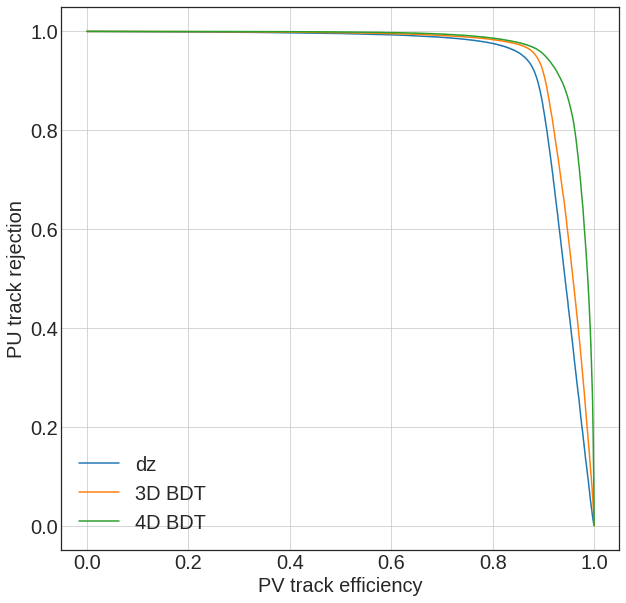

In [30]:
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np

rocDz = roc_curve(y_test, 1.-X_test['dz']/X_test['dz'].max(), sample_weight=w_test)

roc3D = roc_curve(y_test, y_pred_prob_3D[:,1], sample_weight=w_test)

roc4D = roc_curve(y_test, y_pred_prob_4D[:,1], sample_weight=w_test)

hrocDz = plt.plot(rocDz[1], 1-rocDz[0], label='dz')
hroc3D = plt.plot(roc3D[1], 1-roc3D[0], label='3D BDT')
hroc4D = plt.plot(roc4D[1], 1-roc4D[0], label='4D BDT')
plt.xlabel('PV track efficiency')
plt.ylabel('PU track rejection')
plt.grid()
plt.legend()

print(roc_auc_score(y_test, 1.-X_test['dz']/X_test['dz'].max(), sample_weight=w_test),
      roc_auc_score(y_test, y_pred_prob_3D[:,1], sample_weight=w_test),
      roc_auc_score(y_test, y_pred_prob_4D[:,1], sample_weight=w_test)
)

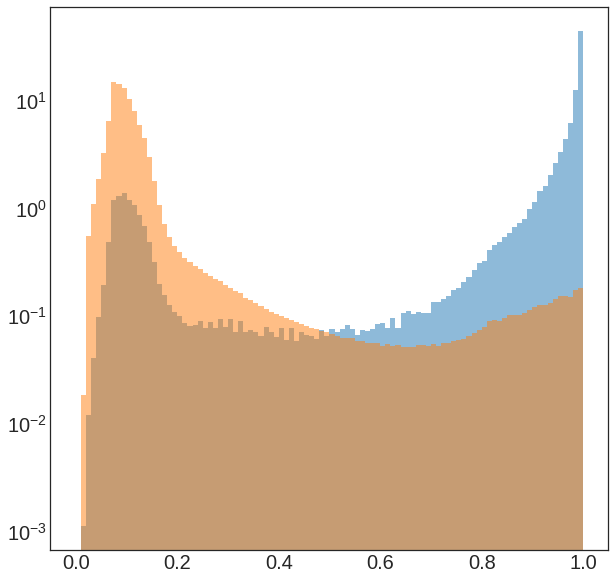

In [ ]:
hpv3D = plt.hist(y_pred_prob_3D[(y_test==1),1], range=[0, 1], bins=100, normed=True, alpha=0.5)
hpu3D = plt.hist(y_pred_prob_3D[(y_test==0),1], range=[0, 1], bins=100, normed=True, alpha=0.5)
plt.yscale('log')

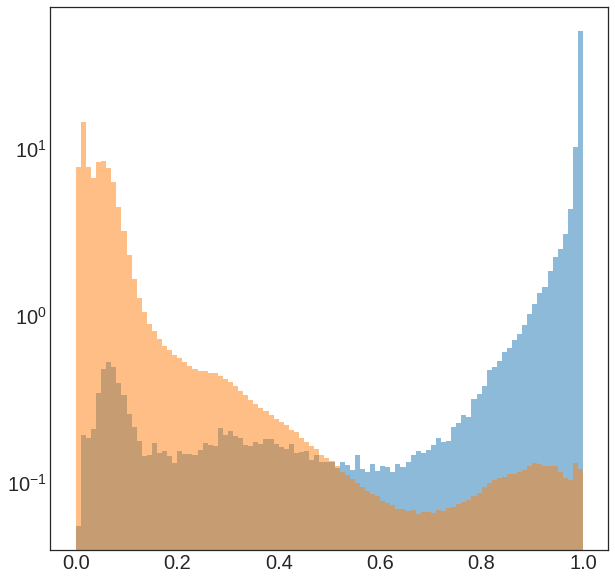

In [34]:
hpv4D = plt.hist(y_pred_prob_4D[(y_test==1),1], range=[0, 1], bins=100, normed=True, alpha=0.5)
hpu4D = plt.hist(y_pred_prob_4D[(y_test==0),1], range=[0, 1], bins=100, normed=True, alpha=0.5)
plt.yscale('log')

In [74]:
X_rew, X_rewt, y_rew, y_rewt, w_rew, w_rewt = train_test_split(X.head(1000000), y.head(1000000), w.head(1000000), test_size=0., random_state=12345)

In [75]:
reweight_clf = XGBClassifier(max_depth=3, n_estimators=200, nthread=8, objective='binary:logistic', subsample=0.75)

In [76]:
reweight_clf.fit(X_rew[['pt', 'eta']], y_rew, w_rew)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=8, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.75)

In [ ]:
rew_eta_pt = reweight_clf.predict_proba(X_train)

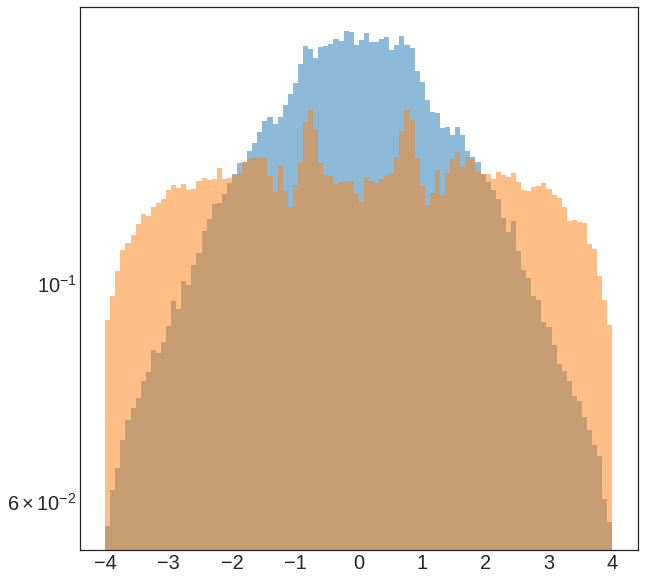

In [ ]:
eta_pt_weight = 

ptpv = plt.hist(X_train['eta'][y_train==1], range=(-4,4), bins=100, alpha=0.5, normed=True, weights=)
ptpu = plt.hist(X_train['eta'][y_train==0], range=(-4,4), bins=100, alpha=0.5, normed=True)
plt.yscale('log')

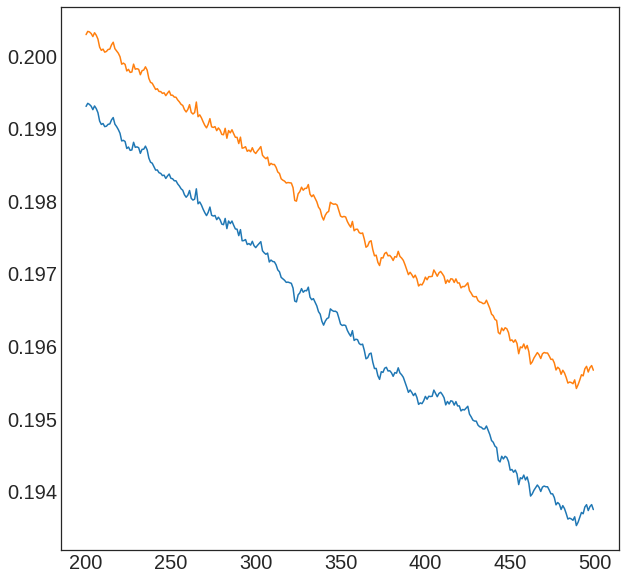

In [35]:
import pickle
clf3D = pickle.load(open("TEST_track_puid_3D_cfl.pkl", "rb"))
results = fitres3D.evals_result()
fig, ax = plt.subplots()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
ax.plot(x_axis[200:], results['validation_0']['logloss'][200:], label='Train')
ax.plot(x_axis[200:], results['validation_1']['logloss'][200:], label='Test')